In [1]:
import numpy as np
import pandas as pd 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras import utils  
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import cv2
import warnings
warnings.filterwarnings("ignore")

In [2]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

#### Prepare training data

In [28]:
filenames = os.listdir("E:/Data science/projects/Machine learning assignment/project 19/16263469/DS May - 05th Nov/Fire-20231126T063341Z-001/Fire")
categories = []
for filename in filenames:
    category = filename.split('_')[0]
    if category == 'fire':
        categories.append(1)
    else:
        categories.append(0)

fire_df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [29]:
fire_df.head()

,filename,category
0,0.jpg,0
1,1.jpg,0
2,10.jpg,0
3,100.jpg,0
4,101.jpg,0


In [30]:
fire_df.tail()

,filename,category
196,95.jpg,0
197,96.jpg,0
198,97.jpg,0
199,98.jpg,0
200,99.jpg,0


#### total count

<Axes: >

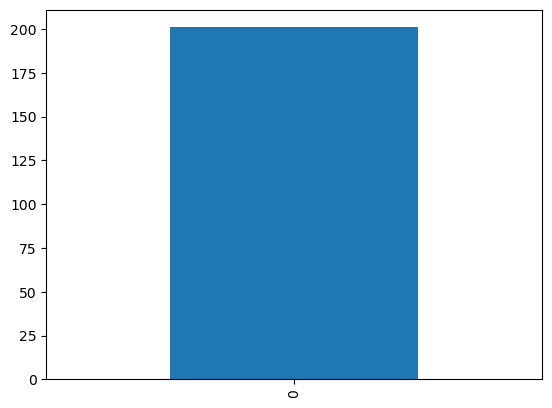

In [31]:
fire_df['category'].value_counts().plot.bar()

In [32]:
fire_df['category'].value_counts()

0    201
Name: category, dtype: int64

#### our data shows we have 201 no fire

#### sample 

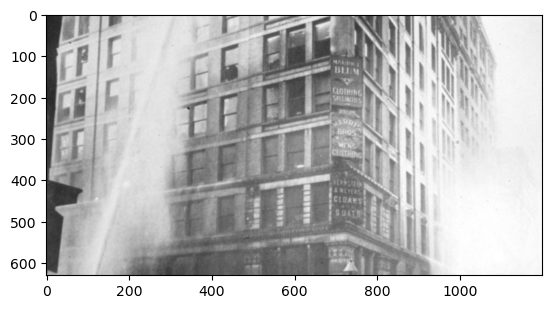

In [33]:
sample = random.choice(filenames)
image = load_img("E:/Data science/projects/Machine learning assignment/project 19/16263469/DS May - 05th Nov/Fire-20231126T063341Z-001/Fire/"+sample)
plt.imshow(image)

### build model

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) 

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_8 (Bat  (None, 126, 126, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 63, 63, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_9 (Bat  (None, 61, 61, 64)       

### callbacks

In [37]:
earlystop = EarlyStopping(patience=10)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

### prepare data

In [38]:
fire_df["category"] = fire_df["category"].replace({0: 'NoFire', 1: 'Fire'}) 

In [39]:
train_fire_df, validate_fire_df = train_test_split(fire_df, test_size=0.20, random_state=42)
train_fire_df = train_fire_df.reset_index(drop=True)
validate_fire_df = validate_fire_df.reset_index(drop=True)

<Axes: >

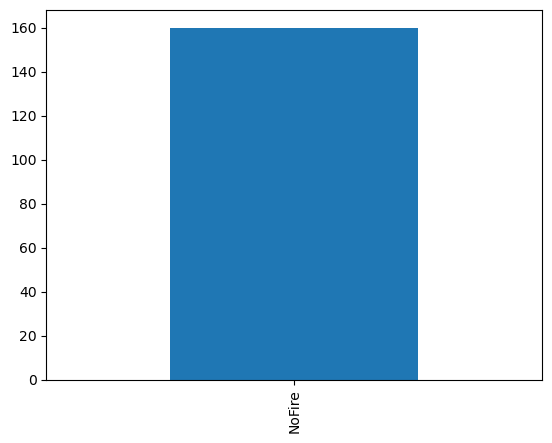

In [40]:
train_fire_df['category'].value_counts().plot.bar()

<Axes: >

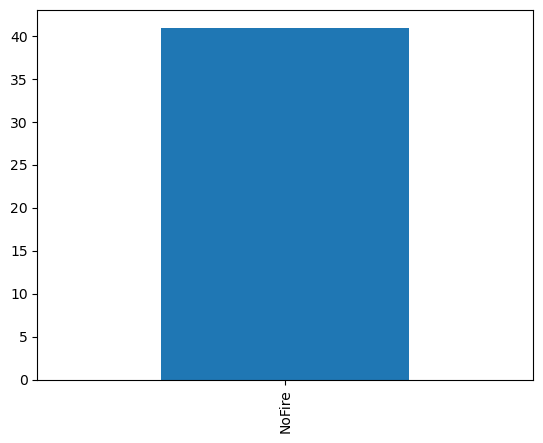

In [41]:
validate_fire_df['category'].value_counts().plot.bar()

In [42]:
total_train = train_fire_df.shape[0]
total_validate = validate_fire_df.shape[0]
batch_size=15

#### training generator

In [43]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_fire_df, 
    "E:/Data science/projects/Machine learning assignment/project 19/16263469/DS May - 05th Nov/Fire-20231126T063341Z-001/Fire", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 160 validated image filenames belonging to 1 classes.


#### validation generator

In [44]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_fire_df, 
    "E:/Data science/projects/Machine learning assignment/project 19/16263469/DS May - 05th Nov/Fire-20231126T063341Z-001/Fire", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 41 validated image filenames belonging to 1 classes.


#### how generator works

In [46]:
example_fire_df = train_fire_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_fire_df, 
    "E:/Data science/projects/Machine learning assignment/project 19/16263469/DS May - 05th Nov/Fire-20231126T063341Z-001/Fire", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


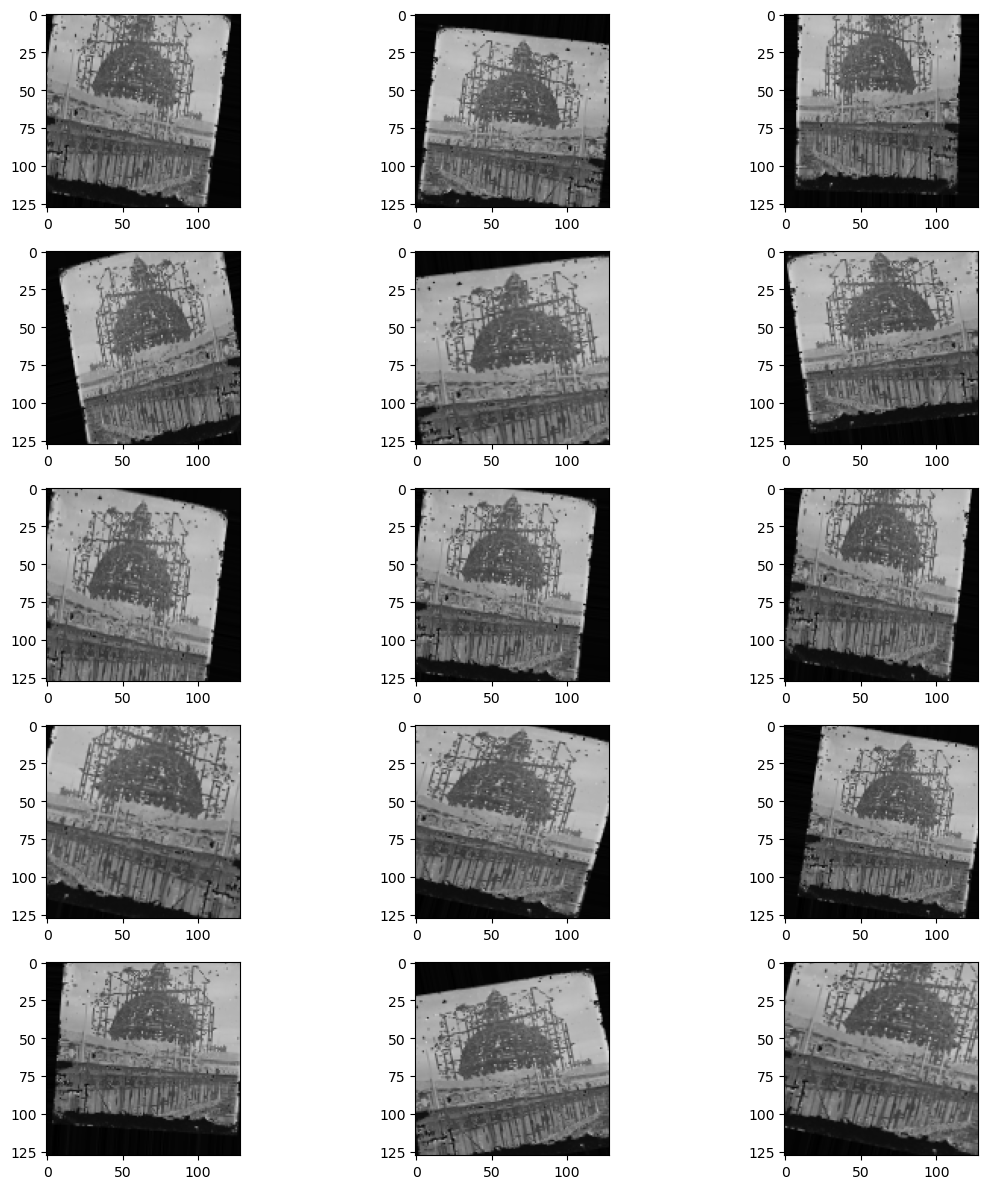

In [49]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

#### fit model

In [50]:
epochs=3 if FAST_RUN else 50
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)
model.save("model.h5")

Epoch 1/50


10/10 [==============================] - 17s 2s/step - loss: 3.6527 - accuracy: 0.4621 - val_loss: 1.4831 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 2/50
10/10 [==============================] - 12s 1s/step - loss: 2.2844 - accuracy: 0.5241 - val_loss: 1.5930 - val_accuracy: 0.6333 - lr: 0.0010
Epoch 3/50
10/10 [==============================] - 13s 1s/step - loss: 2.0089 - accuracy: 0.5655 - val_loss: 2.0339 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 4/50
10/10 [==============================] - 13s 1s/step - loss: 2.2195 - accuracy: 0.4552 - val_loss: 1.8779 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 5/50
10/10 [==============================] - ETA: 0s - loss: 2.1582 - accuracy: 0.4828
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
10/10 [==============================] - 16s 2s/step - loss: 2.1582 - accuracy: 0.4828 - val_loss: 1.6583 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 6/50
10/10 [==============================] - 18s 2s/step - loss: 2.

#### visualize training

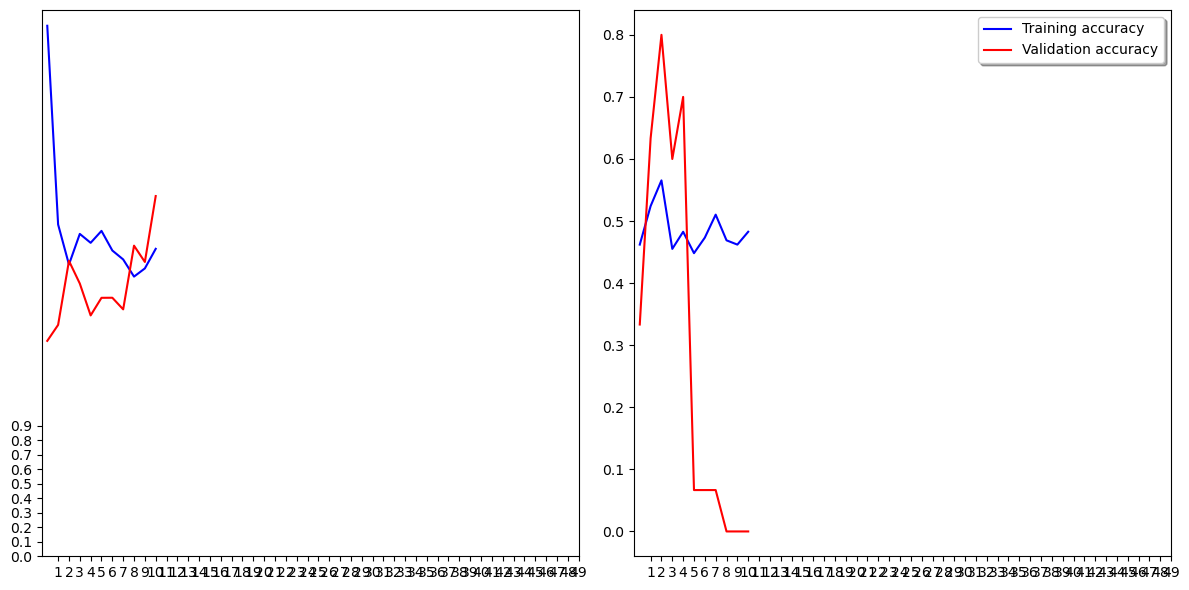

In [51]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [ ]:
for i in range(10):
    all_test_images = os.listdir("E:/Data science/projects/Machine learning assignment/project 19/16263469/DS May - 05th Nov/Fire-20231126T063341Z-001/Fire")
    random_image = random.choice(all_test_images)
    img = cv2.imread(f'E:/Data science/projects/Machine learning assignment/project 19/16263469/DS May - 05th Nov/Fire-20231126T063341Z-001/Fire/{random_image}')
    img = cv2.resize(img,(IMAGE_HEIGHT,IMAGE_WIDTH))
    
    org = img.copy()
    img = img.reshape(1,128,128,3)
    
    pred = model.predict(img)
    print(['NoFire','Fire'][int(pred[0][0])])
    cv2.imshow('Live predictions',org)
    cv2.waitKey(0)
cv2.destroyAllWindows()

1/1 [==============================] - 0s 236ms/step
Fire
